In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
from utils.common import (
    m2f_dataset_collate,
    m2f_extract_pred_maps_and_masks,
    BG_VALUE,
    set_seed,
    pixel_mean_std,
    CADIS_PIXEL_MEAN,
    CADIS_PIXEL_STD,
    CAT1K_PIXEL_MEAN,
    CAT1K_PIXEL_STD,
)
from utils.dataset_utils import (
    get_cadisv2_dataset,
    get_cataract1k_dataset,
    ZEISS_CATEGORIES,
)
from utils.medical_datasets import Mask2FormerDataset
from transformers import (
    Mask2FormerForUniversalSegmentation,
    SwinModel,
    SwinConfig,
    Mask2FormerConfig,
    AutoImageProcessor,
    Mask2FormerImageProcessor
)
from torch.utils.data import DataLoader
import evaluate
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from dotenv import load_dotenv
import wandb

/notebooks/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/notebooks/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
set_seed(42) # seed everything

In [40]:
NUM_CLASSES = len(ZEISS_CATEGORIES) - 3  # Remove class incremental
SWIN_BACKBONE = "microsoft/swin-tiny-patch4-window7-224"#"microsoft/swin-large-patch4-window12-384"

# Download pretrained swin model
swin_model = SwinModel.from_pretrained(
    SWIN_BACKBONE, out_features=["stage1", "stage2", "stage3", "stage4"]
)
swin_config = SwinConfig.from_pretrained(
    SWIN_BACKBONE, out_features=["stage1", "stage2", "stage3", "stage4"]
)

# Create Mask2Former configuration based on Swin's configuration
mask2former_config = Mask2FormerConfig(
    backbone_config=swin_config, num_labels=NUM_CLASSES #, ignore_value=BG_VALUE
)

# Create the Mask2Former model with this configuration
model = Mask2FormerForUniversalSegmentation(mask2former_config)

# Reuse pretrained parameters
for swin_param, m2f_param in zip(
    swin_model.named_parameters(),
    model.model.pixel_level_module.encoder.named_parameters(),
):
    m2f_param_name = f"model.pixel_level_module.encoder.{m2f_param[0]}"

    if swin_param[0] == m2f_param[0]:
        model.state_dict()[m2f_param_name].copy_(swin_param[1])
        continue

    print(f"Not Matched: {m2f_param[0]} != {swin_param[0]}")

/notebooks/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Not Matched: hidden_states_norms.stage1.weight != layernorm.weight
Not Matched: hidden_states_norms.stage1.bias != layernorm.bias


In [41]:
# Helper function to load datasets
def load_dataset(dataset_getter, data_path, domain_incremental):
    return dataset_getter(data_path, domain_incremental=domain_incremental)


# Helper function to create dataloaders for a dataset
def create_dataloaders(
    dataset, batch_size, shuffle, num_workers, drop_last, pin_memory, collate_fn
):
    return {
        "train": DataLoader(
            dataset["train"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            drop_last=drop_last,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
        ),
        "val": DataLoader(
            dataset["val"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            drop_last=drop_last,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
        ),
        "test": DataLoader(
            dataset["test"],
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            drop_last=drop_last,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
        ),
    }


# Load datasets
datasets = {
    "A": load_dataset(get_cadisv2_dataset, "../../storage/data/CaDISv2", True),
    "B": load_dataset(get_cataract1k_dataset, "../../storage/data/cataract-1k", True),
}

# pixel_mean_A,pixel_std_A=pixel_mean_std(datasets["A"][0])
pixel_mean_A = CADIS_PIXEL_MEAN
pixel_std_A = CADIS_PIXEL_STD

# pixel_mean_B,pixel_std_B=pixel_mean_std(datasets["B"][0])
pixel_mean_B = CAT1K_PIXEL_MEAN
pixel_std_B = CAT1K_PIXEL_STD

# Define preprocessor
swin_processor = AutoImageProcessor.from_pretrained(SWIN_BACKBONE)
m2f_preprocessor_A = Mask2FormerImageProcessor(
    reduce_labels=True,
    ignore_index=255,
    do_resize=False,
    do_rescale=True,
    do_normalize=True,
    image_std=pixel_std_A,
    image_mean=pixel_mean_A,
)

m2f_preprocessor_B = Mask2FormerImageProcessor(
    reduce_labels=True,
    ignore_index=255,
    do_resize=False,
    do_rescale=True,
    do_normalize=True,
    image_std=pixel_std_B,
    image_mean=pixel_mean_B,
)

# Create Mask2Former Datasets
m2f_datasets = {
    "A": {
        "train": Mask2FormerDataset(datasets["A"][0], m2f_preprocessor_A),
        "val": Mask2FormerDataset(datasets["A"][1], m2f_preprocessor_A),
        "test": Mask2FormerDataset(datasets["A"][2], m2f_preprocessor_A),
    },
    "B": {
        "train": Mask2FormerDataset(datasets["B"][0], m2f_preprocessor_B),
        "val": Mask2FormerDataset(datasets["B"][1], m2f_preprocessor_B),
        "test": Mask2FormerDataset(datasets["B"][2], m2f_preprocessor_B),
    },
}

# DataLoader parameters
N_WORKERS = 4
BATCH_SIZE = 1
SHUFFLE = True
DROP_LAST = True

dataloader_params = {
    "batch_size": BATCH_SIZE,
    "shuffle": SHUFFLE,
    "num_workers": N_WORKERS,
    "drop_last": DROP_LAST,
    "pin_memory": True,
    "collate_fn": m2f_dataset_collate,
}

# Create DataLoaders
dataloaders = {
    key: create_dataloaders(m2f_datasets[key], **dataloader_params)
    for key in m2f_datasets
}

print(dataloaders)

/notebooks/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


{'A': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f6399ad7610>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f63e95fb110>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f63b422b4d0>}, 'B': {'train': <torch.utils.data.dataloader.DataLoader object at 0x7f639a04b190>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f639a0483d0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f639a048090>}}


In [6]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [7]:
# Tensorboard setup
out_dir="outputs/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
if not os.path.exists(out_dir+"runs"):
    os.makedirs(out_dir+"runs")
%load_ext tensorboard
%tensorboard --logdir outputs/runs

In [42]:
# Training
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
LR_MULTIPLIER = 0.1
BACKBONE_LR = LEARNING_RATE * LR_MULTIPLIER
WEIGHT_DECAY = 0.05
metric = evaluate.load("mean_iou")
encoder_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.pixel_level_module.encoder")
]
decoder_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.pixel_level_module.decoder")
]
transformer_params = [
    param
    for name, param in model.named_parameters()
    if name.startswith("model.transformer_module")
]
optimizer = optim.AdamW(
    [
        {"params": encoder_params, "lr": BACKBONE_LR},
        {"params": decoder_params},
        {"params": transformer_params},
    ],
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

scheduler = optim.lr_scheduler.PolynomialLR(
    optimizer, total_iters=NUM_EPOCHS, power=0.9
)

In [9]:
# WandB for team usage !!!!

wandb.login() # use this one if a different person is going to run the notebook
#wandb.login(relogin=False) # if the same person in the last run is going to run the notebook again


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [43]:
wandb.init(
    project="M2F_original",
    config={
        "learning_rate": LEARNING_RATE,
        "learning_rate_multiplier": LR_MULTIPLIER,
        "backbone_learning_rate": BACKBONE_LR,
        "learning_rate_scheduler": scheduler.__class__.__name__,
        "optimizer": optimizer.__class__.__name__,
        "backbone": SWIN_BACKBONE,
        "m2f_preprocessor": m2f_preprocessor_A.__dict__,
        "m2f_model_config": model.config
    },
    name="M2F-Swin-Tiny-Train_OVERFIT",
    notes="M2F-Swin-Tiny-Train_OVERFIT"
)

In [44]:
# Tensorboard logging
writer = SummaryWriter(log_dir=out_dir + "runs")

# Model checkpointing
base_model_name="m2f_swin_backbone_train_cadis_overfit"
model_dir = out_dir + "models/"
if not os.path.exists(model_dir):
    print("Store weights in: ", model_dir)
    os.makedirs(model_dir)

best_model_dir = model_dir + f"{base_model_name}/best_model/"
if not os.path.exists(best_model_dir):
    print("Store best model weights in: ", best_model_dir)
    os.makedirs(best_model_dir)
final_model_dir = model_dir + f"{base_model_name}/final_model/"
if not os.path.exists(final_model_dir):
    print("Store final model weights in: ", final_model_dir)
    os.makedirs(final_model_dir)

In [45]:
m2f_preprocessor_A.save_pretrained(model_dir + base_model_name)

['outputs/models/m2f_swin_backbone_train_cadis_overfit/preprocessor_config.json']

In [46]:
test_batch = next(iter(dataloaders["A"]["train"]))

In [14]:
test_batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'mask_labels', 'class_labels'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


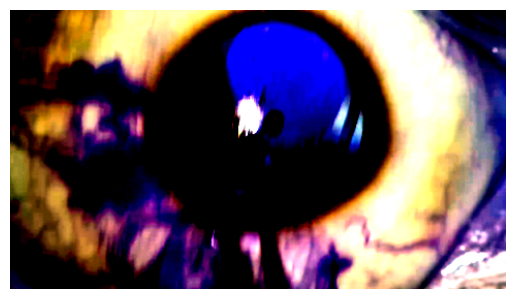

In [35]:
import numpy as np
import matplotlib.pyplot as plt

image_array = test_batch["pixel_values"]

image_array = image_array.squeeze().permute(1, 2, 0).numpy()

# Display the image using Matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axes
plt.show()

In [51]:
test_batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'mask_labels', 'class_labels'])

In [99]:
test_batch['mask_labels'][0].shape

torch.Size([3, 270, 480])

In [95]:
test_batch["class_labels"]

[tensor([ 7,  9, 10])]

In [79]:
np.unique(test_batch['mask_labels'][0])

array([0., 1.], dtype=float32)

In [26]:
a = np.array([1,2,3,4,4])
np.unique(a)

array([1, 2, 3, 4])

In [47]:
batch = next(iter(dataloaders[CURR_TASK]["train"]))

In [48]:
# To avoid making stupid errors

NUM_EPOCHS = 500
CURR_TASK = "A"

# For storing the model
best_val_metric = -np.inf

# Move model to device
model.to(device)

# Get a single data point from the training data


for epoch in range(NUM_EPOCHS):
    model.train()
    

    # Move everything to the device
    batch["pixel_values"] = batch["pixel_values"].to(device)
    batch["pixel_mask"] = batch["pixel_mask"].to(device)
    batch["mask_labels"] = [entry.to(device) for entry in batch["mask_labels"]]
    batch["class_labels"] = [entry.to(device) for entry in batch["class_labels"]]

    # Compute output and loss
    outputs = model(**batch)

    loss = outputs.loss

    # Compute gradient and perform step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record losses
    current_loss = loss.item()

    # Extract and compute metrics
    pred_maps, masks = m2f_extract_pred_maps_and_masks(
        batch, outputs, m2f_preprocessor_A
    )
    metric.add_batch(references=masks, predictions=pred_maps)

    # After compute the batches that were added are deleted
    mean_train_iou = metric.compute(
        num_labels = NUM_CLASSES, ignore_index=BG_VALUE, reduce_labels=False
    )["mean_iou"]

   # Validation phase
    model.eval()

    writer.add_scalar(f"Loss/train_{base_model_name}_{CURR_TASK}", current_loss, epoch + 1)
    writer.add_scalar(f"mIoU/train_{base_model_name}_{CURR_TASK}", mean_train_iou, epoch + 1)

    wandb.log({
        f"Loss/train_{CURR_TASK}": current_loss,
        # f"Loss/val_{CURR_TASK}": epoch_val_loss,
        f"mIoU/train_{CURR_TASK}": mean_train_iou,
        # f"mIoU/val_{CURR_TASK}": mean_val_iou
    })


    tqdm.write(
        f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {current_loss:.4f}, Train mIoU: {mean_train_iou:.4f}"
    )


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Epoch 1/500, Train Loss: 127.7850, Train mIoU: 0.0185
Epoch 2/500, Train Loss: 111.8160, Train mIoU: 0.0185
Epoch 3/500, Train Loss: 102.0796, Train mIoU: 0.0777
Epoch 4/500, Train Loss: 97.3406, Train mIoU: 0.0777
Epoch 5/500, Train Loss: 94.4233, Train mIoU: 0.0777
Epoch 6/500, Train Loss: 93.9191, Train mIoU: 0.0777
Epoch 7/500, Train Loss: 92.8302, Train mIoU: 0.0777
Epoch 8/500, Train Loss: 91.4327, Train mIoU: 0.1371
Epoch 9/500, Train Loss: 91.2631, Train mIoU: 0.1371
Epoch 10/500, Train Loss: 91.1265, Train mIoU: 0.1371
Epoch 11/500, Train Loss: 91.0838, Train mIoU: 0.1371
Epoch 12/500, Train Loss: 90.6513, Train mIoU: 0.1371
Epoch 13/500, Train Loss: 90.4724, Train mIoU: 0.0777
Epoch 14/500, Train Loss: 90.2872, Train mIoU: 0.0777
Epoch 15/500, Train Loss: 90.0460, Train mIoU: 0.0777
Epoch 16/500, Train Loss: 89.8247, Train mIoU: 0.0777
Epoch 17/500, Train Loss: 89.9944, Train mIoU: 0.0777
Epoch 18/500, Train Loss: 89.3361, Train mIoU: 0.0777
Epoch 19/500, Train Loss: 89.0507,

In [42]:
!pip install matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'): 0 pixels


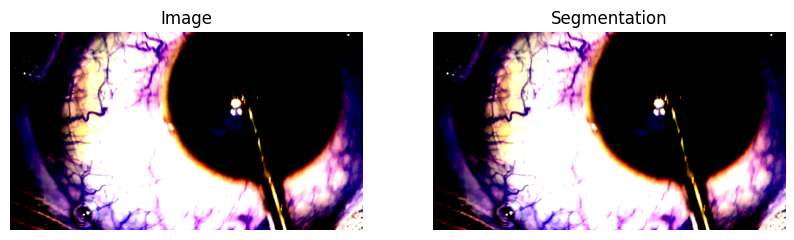

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def visualize_segmentation(batch, mask_labels):
    image = batch["pixel_values"][0]  # Assuming only one image in the batch
    pixel_mask = batch["pixel_mask"][0]  # Assuming only one image in the batch

    plt.figure(figsize=(10, 5))

    # Convert CUDA tensor to NumPy array
    if torch.is_tensor(image):
        image = image.cpu().numpy()
    if torch.is_tensor(pixel_mask):
        pixel_mask = pixel_mask.cpu().numpy()

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image.transpose(1, 2, 0))  # Transpose image dimensions if necessary
    plt.title('Image')
    plt.axis('off')

    # Display the segmentation masks
    plt.subplot(1, 2, 2)
    plt.imshow(image.transpose(1, 2, 0))  # Transpose image dimensions if necessary
    cmap = ListedColormap(np.random.rand(len(mask_labels), 3))
    for j, label in enumerate(mask_labels):
        mask = pixel_mask == j
        plt.contour(mask, levels=[0.5], colors=[cmap(j)], alpha=0.8)  # Adjust contour levels if necessary
        print(f"Label {label}: {np.sum(mask)} pixels")
    plt.title('Segmentation')
    plt.axis('off')

    plt.show()

# Assuming batch1 contains the necessary data


visualize_segmentation(batch, batch["mask_labels"])


In [53]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'mask_labels', 'class_labels'])

In [72]:
batch["pixel_mask"][0].shape

torch.Size([270, 480])

In [61]:
np.unique(pixel_mask_numpy)

array([1])